# ABP Soton Marathon, Half-Marathon and 10k Results Tear-Down

---

On the 23rd of April 2017, Southampton hosted the ABP Soton Marathon, Half-Marathon and 10k (http://www.abpsouthamptonhalf.co.uk/). I did the 10k, and a number of my Astro-colleagues took part in the various distances. The results were available as a csv download - so naturally I thought I would take a look. I'm hoping that I'll be able to get some use out of `pandas`, which I've only used in passing before.

---

First, import the packages I'll be using, and define some functions to help me tidy up the data - there are a few DNF and DNS values as well as some 99:99:99 timestamps, which could trip us up.

In [39]:
# %matplotlib notebook
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.time import Time

In [40]:
def convert_to_ap_Time(df, key):
    print(key)
    df[key] = pd.to_datetime(df[key])
    df[key] = Time([t1.astype(str) for t1 in  df[key].values], format="isot")
    return df

def convert_to_Timedelta(x):
    pd.to_datetime()

    
def convert_times_to_datetime(df):
    columns = ["Gun Time", "Chip Time", "TOD", "Beat the Bridge", "Beat the Bridge.1"]
    
    for key in columns:
        df = convert_to_ap_Time(df, key)
        df = convert_Time_to_seconds(df, key)
    return df

def convert_Time_to_seconds(df, key):
    t0 = Time("2017-05-04T00:00:00.000", format="isot")
    df["sub" + key] = df[key] - t0
    df["sub" + key] = [t.sec for t in df["sub" + key].values]
    return df

def find_astronomers(df):
    astronomers = ("Robert FIRTH", "Stephen BROWETT", "Mathew SMITH", "Sadie JONES")
    astro_df = df[df["Name"].isin((astronomers))]
    return astro_df

def plot_hist_with_astronomers(df, astro_df, key):
    rob_time = astro_df[key][158]/60.
    mat_time = astro_df[key][737]/60.
    steve_time = astro_df[key][1302]/60.
    sadie_time = astro_df[key][576]/60.

    mean_time = df[key].mean()/60
    median_time = df[key].median()/60

    plt.hist(df[key]/60., bins = 100)

    plt.plot([rob_time, rob_time], [0, 70], lw = 2, label = "Rob")
    plt.plot([mat_time, mat_time], [0, 70], lw = 2, label = "Mat")
    plt.plot([steve_time, steve_time], [0, 70], lw = 2, label = "Steve")
    plt.plot([sadie_time, sadie_time], [0, 70], lw = 2, label = "Sadie")

    plt.plot([mean_time, mean_time], [0, 70], lw = 2, color = "Black", ls = ":", label = "Mean")
    plt.plot([median_time, median_time], [0, 70], lw = 2, color = "Black", ls = "--", label = "Median")
    plt.xlabel(key.replace("sub", "") + " Minutes")

    plt.legend()

## Loading the data
---

As mentioned above, the data was released as a pretty straightforward `.csv` file, so I'll just pull it into a `pandas` `dataframe` so I can easily interact with it. 

In [41]:
results_path = "/Users/berto/Code/zoidberg/ABPSoton10k/data/Results10k.csv"

df = pd.read_csv(results_path)
origlength = len(df)
print("Original Length = ", origlength)
# df = df.drop(df.index[len(df)-10:])
df = df.drop(df.loc[df["Gun Time"] == "DNF"].index)
newlen = len(df)
print("Dropping ", origlength - len(df), " rows that Gun Time = 'DNF'")
df = df.drop(df.loc[df["Gun Time"] == "QRY"].index)
print("Dropping ", newlen - len(df), " rows that Gun Time = 'QRY'")
newlen = len(df)
df = df.drop(df.loc[df["Beat the Bridge"] == "99:99:99"].index)
print("Dropping ", newlen - len(df), " rows that have bad 'Beat the Bridge' time")
newlen = len(df)
print("final length = ", newlen)

Original Length =  1626
Dropping  9  rows that Gun Time = 'DNF'
Dropping  1  rows that Gun Time = 'QRY'
Dropping  3  rows that have bad 'Beat the Bridge' time
final length =  1613


Now we have Let's take a look at what info we have in the table:

In [42]:
# df.columns
df.head()

,Pos,Bib No,Fav,Share,Print,Name,Gun Time,Chip Time,Category,Cat Pos,Gender,Gen Pos,Club,Pace,TOD,Beat the Bridge,G/Pos,Beat the Bridge.1,G/Pos.1
0,1,1163,NaN,NaN,NaN,James HUGHES,00:36:47.0,00:36:45.3,Top 3,1,Male,1,ITCHEN SPITFIRES/ EALING SOUTHALL AND MIDDLESEX,16.3 km/h,11:06:53.0,00:06:32.4,2,00:06:32.4,2
1,2,143,NaN,NaN,NaN,William BRYAN,00:36:51.7,00:36:49.1,Top 3,2,Male,2,NaN,16.3 km/h,11:06:57.7,00:06:28.6,1,00:06:28.6,1
2,3,1771,NaN,NaN,NaN,Dan SLAYFORD,00:36:57.4,00:36:28.3,Top 3,3,Male,3,FLYERS SOUTHEND,16.2 km/h,11:07:03.4,00:06:33.3,3,00:06:33.3,3
3,4,1320,NaN,NaN,NaN,David BLACKMAN,00:37:18.6,00:37:17.3,V50,1,Male,4,SOUTHAMPTON AC,16.1 km/h,11:07:24.6,00:06:41.0,5,00:06:41.0,5
4,5,1639,NaN,NaN,NaN,David REYNOLDS,00:37:24.4,00:36:50.4,Sen,1,Male,5,LORDSHILL ROADRUNNERS,16.0 km/h,11:07:30.3,00:06:42.4,6,00:06:42.4,6


There are a number of columns that are timestamps, but they are sting formatted. We can convert them into timedeltas using a lambda function and the `to_timedelta` method and simply iterating through the keys we're interested in.

While preserving the data in a new column "$KEYNAME original" as a timedelta, but I will convert the new column to minutes, which are the most natural unit for taking a quick look at this data.

In [43]:
key_list = ["Gun Time", "Chip Time", "Beat the Bridge", "Beat the Bridge.1"]

for key in key_list:
    df[key+" original"] = pd.to_timedelta(df[key].map(lambda x : "0 days " + x ))
    timedelta = pd.to_timedelta(df[key].map(lambda x : "0 days " + x ))
    df[key] = timedelta.map(lambda x : x.seconds/60.)

In [44]:
df.head()

,Pos,Bib No,Fav,Share,Print,Name,Gun Time,Chip Time,Category,Cat Pos,...,Pace,TOD,Beat the Bridge,G/Pos,Beat the Bridge.1,G/Pos.1,Gun Time original,Chip Time original,Beat the Bridge original,Beat the Bridge.1 original
0,1,1163,NaN,NaN,NaN,James HUGHES,36.783333,36.750000,Top 3,1,...,16.3 km/h,11:06:53.0,6.533333,2,6.533333,2,00:36:47,00:36:45.300000,00:06:32.400000,00:06:32.400000
1,2,143,NaN,NaN,NaN,William BRYAN,36.850000,36.816667,Top 3,2,...,16.3 km/h,11:06:57.7,6.466667,1,6.466667,1,00:36:51.700000,00:36:49.100000,00:06:28.600000,00:06:28.600000
2,3,1771,NaN,NaN,NaN,Dan SLAYFORD,36.950000,36.466667,Top 3,3,...,16.2 km/h,11:07:03.4,6.550000,3,6.550000,3,00:36:57.400000,00:36:28.300000,00:06:33.300000,00:06:33.300000
3,4,1320,NaN,NaN,NaN,David BLACKMAN,37.300000,37.283333,V50,1,...,16.1 km/h,11:07:24.6,6.683333,5,6.683333,5,00:37:18.600000,00:37:17.300000,00:06:41,00:06:41
4,5,1639,NaN,NaN,NaN,David REYNOLDS,37.400000,36.833333,Sen,1,...,16.0 km/h,11:07:30.3,6.700000,6,6.700000,6,00:37:24.400000,00:36:50.400000,00:06:42.400000,00:06:42.400000


`pandas` has a bunch of ways of easily chaining methods so you can make borderline unreadble one-liners. However, they are handy!

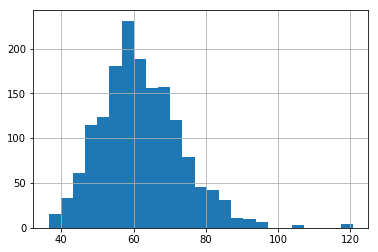

In [45]:
df["Chip Time original"].map(lambda x : x.seconds/60.).hist(bins = 25)

## Find Astronomers!
---
I was one of four Astronomers who ran the 10k (three more did the Half Marathon) - it'll be interesting to see how we stack up.

So to find them, I can use the handy `isin` method, with a list of names:

In [46]:
astronomers = ("Robert FIRTH", "Stephen BROWETT", "Mathew SMITH", "Sadie JONES")
df[df["Name"].isin(astronomers)]

,Pos,Bib No,Fav,Share,Print,Name,Gun Time,Chip Time,Category,Cat Pos,...,Pace,TOD,Beat the Bridge,G/Pos,Beat the Bridge.1,G/Pos.1,Gun Time original,Chip Time original,Beat the Bridge original,Beat the Bridge.1 original
158,159,1662,NaN,NaN,NaN,Robert FIRTH,48.983333,48.116667,Sen,89,...,12.2 km/h,11:19:05.6,8.633333,125,8.633333,125,00:48:59.600000,00:48:07.600000,00:08:38.900000,00:08:38.900000
576,577,1560,NaN,NaN,NaN,Sadie JONES,59.583333,55.000000,Sen,123,...,10.1 km/h,11:29:41.6,9.450000,80,9.450000,80,00:59:35.600000,00:55:00.400000,00:09:27.200000,00:09:27.200000
737,738,1165,NaN,NaN,NaN,Mathew SMITH,61.900000,56.816667,Sen,276,...,9.7 km/h,11:32:00.3,9.866667,316,9.866667,316,01:01:54.300000,00:56:49.400000,00:09:52.100000,00:09:52.100000
1302,1303,1915,NaN,NaN,NaN,Stephen BROWETT,74.916667,69.816667,Sen,364,...,8.0 km/h,11:45:01.0,12.833333,614,12.833333,614,01:14:55,01:09:49.700000,00:12:50.800000,00:12:50.800000


In [47]:
astro_df = find_astronomers(df)

Now we have them, it's probably worth assigning everyone a colour so we can see them a little easier on the plots. We can just use the new `matplotlib 2.0` defaults for ease. 

In [48]:
# astro_df["colour"] = pd.Series(["red", "yellow", "green", "black"], index=astro_df.index)
astro_df["colour"] = pd.Series(["C1", "C2", "C3", "C4"], index=astro_df.index)

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Total time - Chip Time
---
For the run time, we will use the "Chip Time", which is the time logged by the unit on the back of each runner's number when they cross the finish line. Since this only starts counting when the start line is crossed, this is a better measurement than the "Gun Time". However, we will will look into differences between the two in a bit.

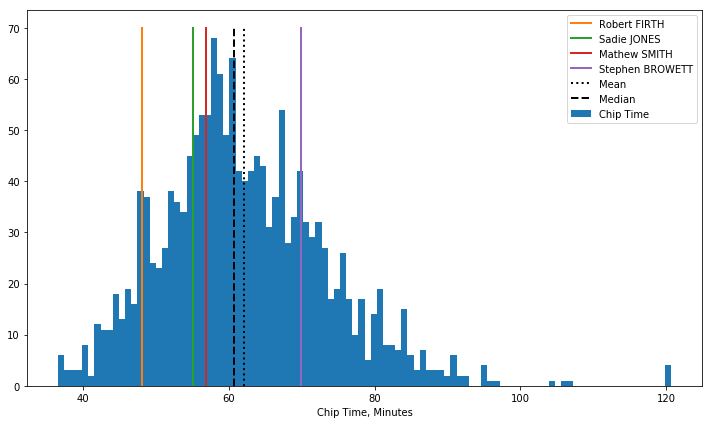

In [49]:
# key = "subGun Time"
key = "Chip Time"

mean_time = df[key].mean()
median_time = df[key].median()

fig = plt.figure(figsize=[10, 6])
ax1 = fig.add_subplot(111)
ax1.hist(df[key], bins = 100)

for astro_indices in astro_df.index:
    runtime = astro_df["Chip Time"][astro_indices]
    ax1.plot([runtime, runtime], [0, 70], lw = 2, label=astro_df["Name"][astro_indices])

ax1.plot([mean_time, mean_time], [0, 70], lw = 2, color = "Black", ls = ":", label = "Mean")
ax1.plot([median_time, median_time], [0, 70], lw = 2, color = "Black", ls = "--", label = "Median")
plt.xlabel(key + ", Minutes")
ax1.legend()
plt.tight_layout()

What does this tell us?
---

In [50]:
# plot_hist_with_astronomers(df=df, astro_df=astro_df, key="Beat the Bridge")

## Chip Time vs Bridge Time

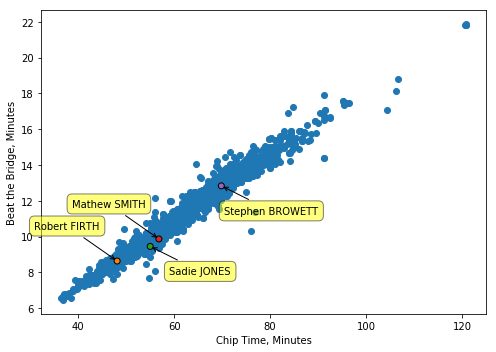

In [51]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

corr_co = np.corrcoef(df[keyx], df[keyy])

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

ax1.scatter(df[keyx], df[keyy])

ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])
plt.xlabel(keyx + ", Minutes")
plt.ylabel(keyy + ", Minutes")
plt.tight_layout()

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(sign*50, -1*sign*30),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


In [52]:
print(corr_co[1,0])

0.981234925419


we can fit a model to this.

In [53]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

z = np.polyfit(df[keyx], df[keyy],1)
p = np.poly1d(z)
fit = p(df[keyx])

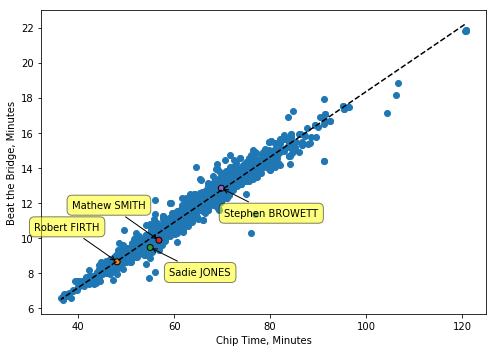

In [54]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

ax1.scatter(df[keyx], df[keyy])

ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])
plt.xlabel(keyx + ", Minutes")
plt.ylabel(keyy + ", Minutes")
plt.tight_layout()

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(sign*50, -1*sign*30),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax1.plot(df[keyx], fit, color = "black", ls = "--")

## Split by Gender
---


In [55]:
gender_groups = df.groupby(df["Gender"])

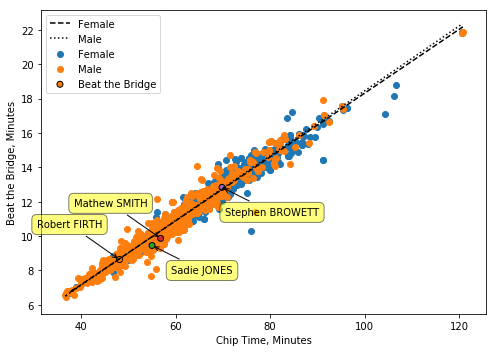

In [56]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

lstyles = ["--",":"]
i = 0
for name, group in gender_groups:
    ax1.scatter(group[keyx], group[keyy], label = name)

    z = np.polyfit(group[keyx], group[keyy],1)
    p = np.poly1d(z)
    fit = p(group[keyx])
    ax1.plot(group[keyx], fit, color = "black", ls = lstyles[i], label = name)
    i+=1
# ax1.scatter(df[keyx].map(lambda x : x.seconds/60.), df[keyy].map(lambda x : x.seconds/60.))

ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])
plt.xlabel(keyx + ", Minutes")
plt.ylabel(keyy + ", Minutes")
plt.tight_layout()

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(sign*50, -1*sign*30),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax1.legend()

Female stddev 0.4066658722883324
Male stddev 0.4286128814884512


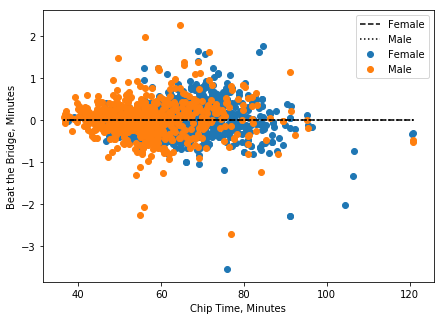

In [57]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

lstyles = ["--",":"]
i = 0
for name, group in gender_groups:

    z = np.polyfit(group[keyx], group[keyy],1)
    p = np.poly1d(z)
    fit = p(group[keyx])
    ax1.scatter(group[keyx], group[keyy]-fit, label = name)
#     ax1.plot(group[keyx], fit, color = "black", ls = lstyles[i], label = name)
    ax1.plot(group[keyx], np.zeros_like(group[keyx]), color = "black", ls = lstyles[i], label = name)
    print(name, "stddev", np.std(group[keyy]-fit))
    i+=1

ax1.set_xlabel(keyx + ", Minutes")
ax1.set_ylabel(keyy + ", Minutes")
ax1.legend()

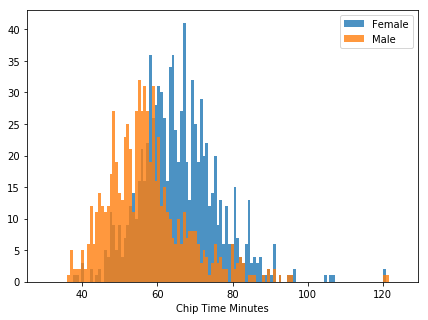

In [58]:
keyx = "Chip Time"

alpha = 0.8

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    x = group[keyx]
    
    plt.hist(x, bins=np.arange(30.0,125.,0.75), alpha = alpha, label = name)
ax1.set_xlabel(keyx + " Minutes")
ax1.legend()

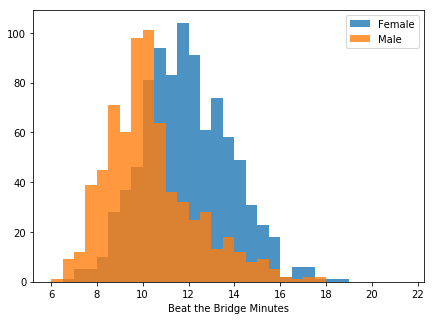

In [59]:
keyy = "Beat the Bridge"

alpha = 0.8

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    y = group[keyy]
    
    ax1.hist(y, bins=np.arange(6.0,22.0, 0.5), alpha = alpha, label = name)
    
ax1.set_xlabel(keyy + " Minutes")
ax1.legend()

## Time vs Bib Number

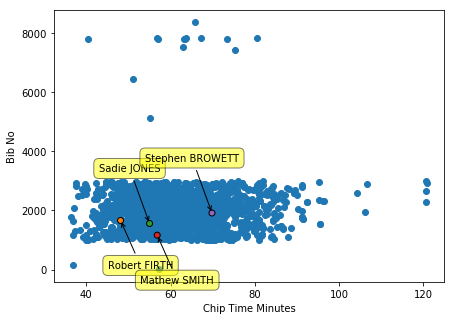

In [60]:
keyx = "Chip Time"
keyy = "Bib No"

corr_co = np.corrcoef(df[keyx], df[keyy])

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

ax1.scatter(df[keyx], df[keyy])

ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(-1*sign*20, sign*50),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.xlabel(keyx + " Minutes")
plt.ylabel(keyy)

In [61]:
print(corr_co[1,0])

0.0808197254961


## Position vs gender position

In [62]:
gender_groups = df.groupby(df["Gender"])

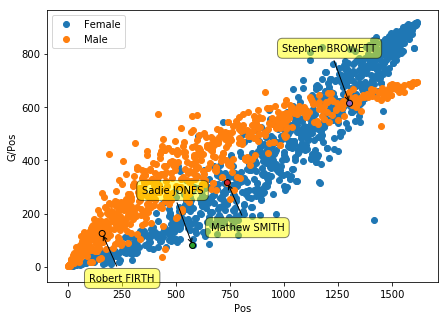

In [63]:
keyx = "Pos"
keyy = "G/Pos"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    ax1.scatter(group[keyx], group[keyy], label = name)
ax1.legend()
ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])


for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    namelabel = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        namelabel,
        xy=(x, y), xytext=(-1*sign*20, sign*50),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.xlabel(keyx)
plt.ylabel(keyy)

(34.944166666666661, 132.94749999999999)

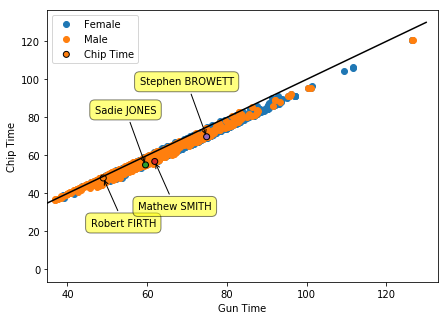

In [64]:
keyx = "Gun Time"
keyy = "Chip Time"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    ax1.scatter(group[keyx], group[keyy], label = name)

ax1.scatter(astro_df[keyx], astro_df[keyy], edgecolor = "black", color = astro_df["colour"])
ax1.legend()

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(-1*sign*20, sign*50),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax1.plot([0,130], [0, 130], color = "black")
ax1.set_xlabel(keyx)
ax1.set_ylabel(keyy)
ax1.set_xlim([df[keyx].min()*0.95, df[keyx].max()*1.05])

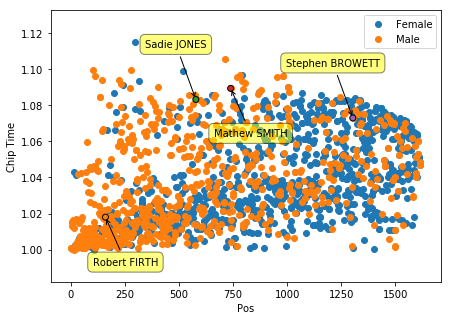

In [65]:
keyx = "Pos"
keyy1 = "Gun Time"
keyy2 = "Chip Time"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    x = group[keyx]
    y = group[keyy1] / group[keyy2]
    ax1.scatter(x,y, label = name)

x = astro_df[keyx]
y = astro_df[keyy1] / astro_df[keyy2]   
ax1.scatter(x, y, edgecolor = "black", color = astro_df["colour"])
ax1.legend()

for i, astro_indices in enumerate(astro_df.index):
    x = astro_df[keyx][astro_indices]
    y = astro_df[keyy1][astro_indices] / astro_df[keyy2][astro_indices]
    label = astro_df["Name"][astro_indices]
    sign = 2*(i%2) - 1

    ax1.annotate(
        label,
        xy=(x, y), xytext=(-1*sign*20, sign*50),
        textcoords='offset points', ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# plt.plot([0,130], [0, 130], color = "black")
plt.xlabel(keyx)
plt.ylabel(keyy)

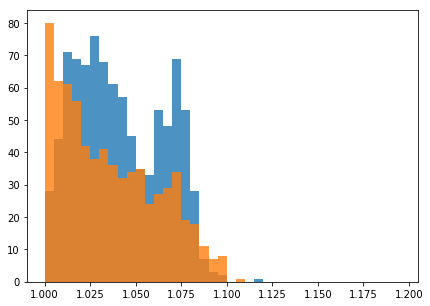

In [66]:
alpha = 0.8

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    x = group[keyx]
    y = group[keyy1] / group[keyy2]
    
    plt.hist(y, bins=np.arange(1.0,1.2,0.005), alpha = alpha)


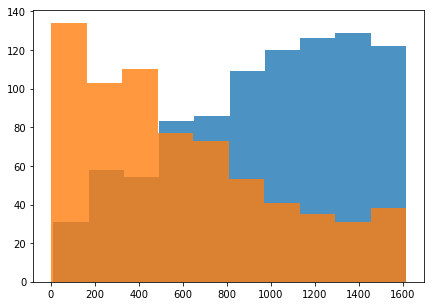

In [67]:
alpha = 0.8

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    x = group[keyx]
    y = group[keyy1] / group[keyy2]
    
    plt.hist(x, alpha = alpha)
  

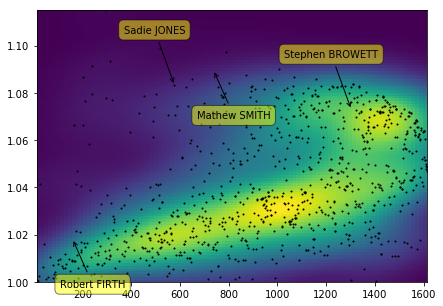

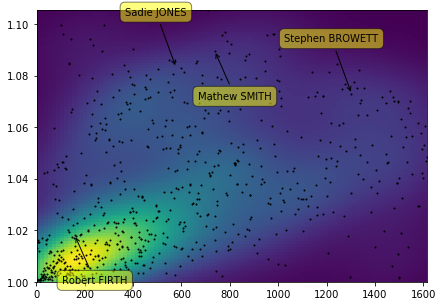

In [68]:
from scipy import stats

for name, group in gender_groups:
    x = group[keyx]
    y = group[keyy1] / group[keyy2]

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    fig = plt.figure(figsize=[7, 5])
    ax = fig.add_subplot(111)

#     ax.imshow(np.rot90(Z))
    ax.pcolormesh(X, Y, Z)
    ax.plot(x, y, 'k.', markersize=2)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    
    for i, astro_indices in enumerate(astro_df.index):
        x_astro = astro_df[keyx][astro_indices]
        y_astro = astro_df[keyy1][astro_indices] / astro_df[keyy2][astro_indices]
        label = astro_df["Name"][astro_indices]
        sign = 2*(i%2) - 1

        ax.annotate(
            label,
            xy=(x_astro, y_astro), xytext=(-1*sign*20, sign*50),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


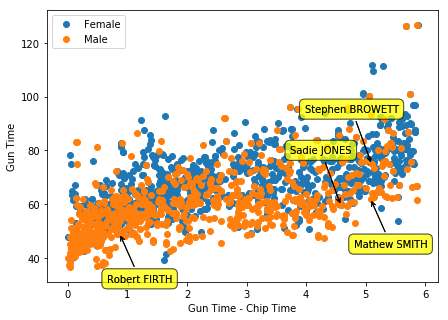

In [92]:
keyx1 = "Gun Time"
keyx2 = "Chip Time"
keyy = "Gun Time"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for name, group in gender_groups:
    ax1.scatter(group[keyx1]  - group[keyx2] ,group[keyy],label=name)
    
    for i, astro_indices in enumerate(astro_df.index):
        x = astro_df[keyx1][astro_indices]  - astro_df[keyx2][astro_indices]
        y = astro_df[keyy][astro_indices]
        label = astro_df["Name"][astro_indices]
        sign = 2*(i%2) - 1

        ax1.annotate(
            label,
            xy=(x, y), xytext=(-1*sign*20, sign*50),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax1.legend()
plt.ylabel(keyy)
plt.xlabel(keyx1 + " - " + keyx2)

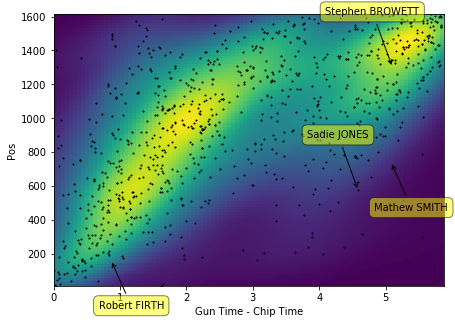

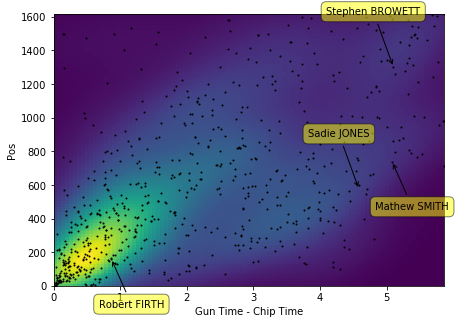

In [94]:
keyx1 = "Gun Time"
keyx2 = "Chip Time"
# keyy = "Gun Time"
# keyy = "G/Pos"
# keyy = "Gen Pos"
keyy = "Pos"

for name, group in gender_groups:
    x = group[keyx1]  - group[keyx2]
    y = group[keyy]

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    fig = plt.figure(figsize=[7, 5])
    ax1 = fig.add_subplot(111)

#     ax.imshow(np.rot90(Z))
    ax1.pcolormesh(X, Y, Z)
    ax1.plot(x, y, 'k.', markersize=2)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    
    for i, astro_indices in enumerate(astro_df.index):
        x_astro = astro_df[keyx1][astro_indices] - astro_df[keyx2][astro_indices]
        y_astro = astro_df[keyy][astro_indices]
        label = astro_df["Name"][astro_indices]
        sign = 2*(i%2) - 1

        ax1.annotate(
            label,
            xy=(x_astro, y_astro), xytext=(-1*sign*20, sign*50),
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

        # ax1.legend()
    ax1.set_ylabel(keyy)
    ax1.set_xlabel(keyx1 + " - " + keyx2)

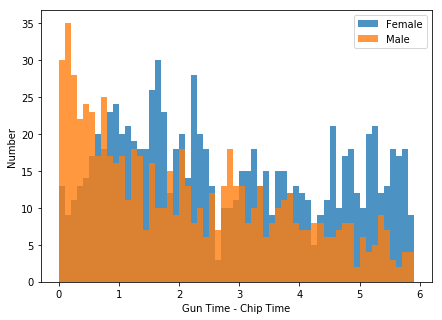

In [98]:
keyx1 = "Gun Time"
keyx2 = "Chip Time"
# keyy = "Gun Time"
# keyy = "G/Pos"
# keyy = "Gen Pos"
keyy = "Pos"

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)
    
for name, group in gender_groups:
    x = group[keyx1]  - group[keyx2]
    y = group[keyy]

    ax1.hist(x, bins=np.arange(0.0,6.0,0.1), alpha = alpha, label=name)

ax1.legend()
ax1.set_ylabel("Number")
ax1.set_xlabel(keyx1 + " - " + keyx2)

## Club Runners
___


In [104]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

labels = ["Non-Club Runner", "Club Runner"]
lstyles = ["--",":"]

for i, indices in enumerate([~df["Club"].isin(df["Club"].dropna()), df["Club"].isin(df["Club"].dropna())]) :
    print(labels[i])
    print(df[indices][keyx].mean(),df[indices][keyy].mean())



Non-Club Runner
62.37529250684582 11.342967388598458
Club Runner
60.5125912408759 10.944951338199505


### Are Club Runners Better at Pacing?

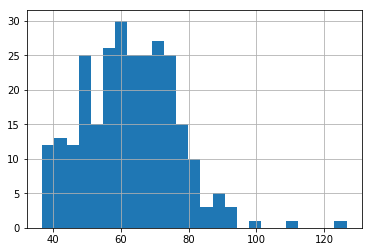

In [99]:
df.loc[df["Club"].dropna().index]["Gun Time"].hist(bins=25)

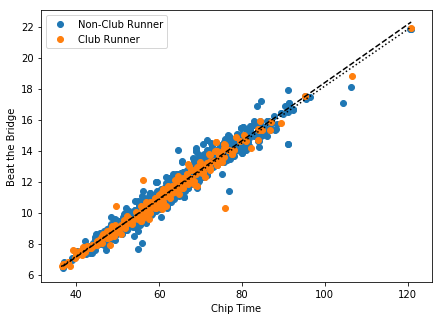

In [100]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

labels = ["Non-Club Runner", "Club Runner"]
lstyles = ["--",":"]

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for i, indices in enumerate([~df["Club"].isin(df["Club"].dropna()), df["Club"].isin(df["Club"].dropna())]) :
    z = np.polyfit(df[indices][keyx], df[indices][keyy],1)
    p = np.poly1d(z)
    fit = p(df[indices][keyx])

    ax1.scatter(df[indices][keyx], df[indices][keyy], label = labels[i])
    ax1.plot(df[indices][keyx], fit, ls = lstyles[i], color = "Black")
    # ax1.scatter(df[df["Club"].isin(df["Club"].dropna())][keyx].map(lambda x : x.seconds/60), df[df["Club"].isin(df["Club"].dropna())][keyy].map(lambda x : x.seconds/60))

ax1.set_xlabel(keyx)
ax1.set_ylabel(keyy)
ax1.legend()


stddev =  0.4177343919656396
stddev =  0.4059051229366308


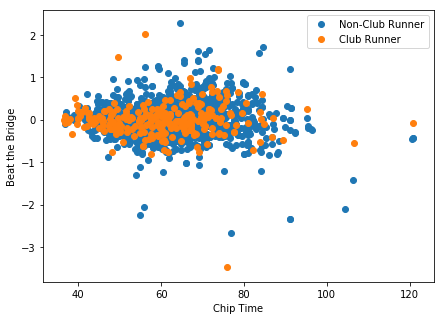

In [72]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

labels = ["Non-Club Runner", "Club Runner"]
lstyles = ["--",":"]

fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for i, indices in enumerate([~df["Club"].isin(df["Club"].dropna()), df["Club"].isin(df["Club"].dropna())]) :
    z = np.polyfit(df[indices][keyx], df[indices][keyy],1)
    p = np.poly1d(z)
    fit = p(df[indices][keyx])

    ax1.scatter(df[indices][keyx], df[indices][keyy]-fit, label = labels[i])
#     ax1.plot(df[indices][keyx], fit, ls = lstyles[i], color = "Black")
    # ax1.scatter(df[df["Club"].isin(df["Club"].dropna())][keyx].map(lambda x : x.seconds/60), df[df["Club"].isin(df["Club"].dropna())][keyy].map(lambda x : x.seconds/60))
    print("stddev = ", np.std(df[indices][keyy]-fit))
    
ax1.set_xlabel(keyx)
ax1.set_ylabel(keyy)
ax1.legend()


stddev =  0.4177343919656396
stddev =  0.4059051229366308


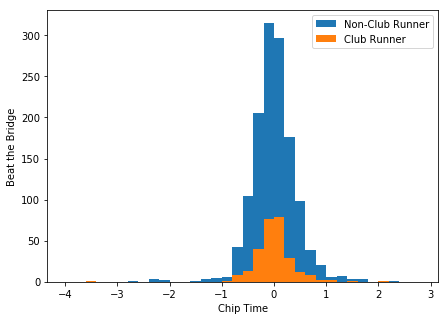

In [73]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

labels = ["Non-Club Runner", "Club Runner"]
bins = np.arange(-4., 3, 0.2)
fig = plt.figure(figsize=[7, 5])
ax1 = fig.add_subplot(111)

for i, indices in enumerate([~df["Club"].isin(df["Club"].dropna()), df["Club"].isin(df["Club"].dropna())]) :
    z = np.polyfit(df[indices][keyx], df[indices][keyy],1)
    p = np.poly1d(z)
    fit = p(df[indices][keyx])

    ax1.hist(df[indices][keyy]-fit, label = labels[i], bins = bins)
    print("stddev = ", np.std(df[indices][keyy]-fit))
    
ax1.set_xlabel(keyx)
ax1.set_ylabel(keyy)
ax1.legend()


stddev =  0.4177343919656396
stddev =  0.4059051229366308


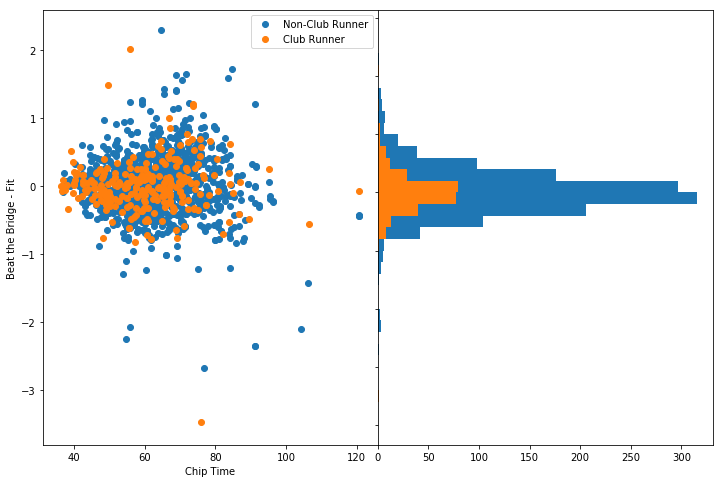

In [77]:
keyx = "Chip Time"
keyy = "Beat the Bridge"

labels = ["Non-Club Runner", "Club Runner"]
lstyles = ["--",":"]

fig = plt.figure(figsize=[12, 8])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, indices in enumerate([~df["Club"].isin(df["Club"].dropna()), df["Club"].isin(df["Club"].dropna())]) :
    z = np.polyfit(df[indices][keyx], df[indices][keyy],1)
    p = np.poly1d(z)
    fit = p(df[indices][keyx])

    ax1.scatter(df[indices][keyx], df[indices][keyy]-fit, label = labels[i])
#     ax1.plot(df[indices][keyx].map(lambda x : x.seconds/60), fit, ls = lstyles[i], color = "Black")
    # ax1.scatter(df[df["Club"].isin(df["Club"].dropna())][keyx].map(lambda x : x.seconds/60), df[df["Club"].isin(df["Club"].dropna())][keyy].map(lambda x : x.seconds/60))
    print("stddev = ", np.std(df[indices][keyy]-fit))
    ax2.hist(df[indices][keyy]-fit, label = labels[i], bins = bins, orientation="horizontal")

fig.subplots_adjust(wspace=0)
ax2.set_yticklabels("")
ax1.set_xlabel(keyx)
ax1.set_ylabel(keyy+ " - Fit")
ax1.legend()


Doesn't look like it!

In [ ]:
# for name, group in club_groups:
#     print(name, group["Chip Time"].map(lambda x : x.seconds/60).mean(), df_1["Chip Time"].map(lambda x : x.seconds/60).mean())

In [ ]:
keyx = "subChip Time"
keyy = "subBeat the Bridge"

corr_co = np.corrcoef(df[keyx][df["Club"].isin(clubs)]/60., df[keyy][df["Club"].isin(clubs)]/60.)

plt.scatter(df[keyx][df["Club"].isin(clubs)]/60., df[keyy][df["Club"].isin(clubs)]/60.)
# plt.scatter(df[keyx][df["Club"].isin(np.invert(clubs))]/60., df[keyy][df["Club"].isin(np.invert(clubs))]/60.)

plt.xlabel(keyx.replace("sub", "") + " Minutes")
plt.ylabel(keyy.replace("sub", "") + " Minutes")


In [ ]:
df[["Club", "Name", "subChip Time"]][df["Club"].isin(clubs)]

In [ ]:
t1 - t0

In [ ]:
col = df["Gun Time"] - t0

In [ ]:
x = col[0]

In [ ]:
x.

In [ ]:
col.sec